# Separating the benchwarmers from the regular starters

In this notebook we explore the separation of our model into 2 steps: i) predict benchwarmers and ii) predict points

## Set-up

In [125]:
import os
import itertools
import pickle

import pandas as pd
import numpy as np
from keras.layers import \
    Dense, \
    LSTM, \
    BatchNormalization, \
    Dropout, \
    Activation
from keras import \
    initializers, \
    optimizers, \
    Sequential
import keras
from hyperopt import hp, fmin, rand, tpe, Trials
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 42

## Load training data

In [6]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [7]:
all_data = load_all_data()

2020-06-10 19:07:26,619 - Loading raw historical FPL data
2020-06-10 19:07:26,856 - Creating season order column
2020-06-10 19:07:26,864 - Generating known features for next GW


In [8]:
print(all_data.shape)
all_data.head()

(67797, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

### Create target

In [10]:
all_data['total_points_plus1_gw'] = all_data.groupby(['name'])['total_points'].shift(-1)
all_data = all_data[~all_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Train/dev/test split

We now added a random_state parameter to `custom_train_test_split` to ensure consistent training sets

In [11]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.09869880673982132
Test set size: (6584, 70)
Training set size: (60124, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.10238839731222141
Test set size: (6156, 70)
Training set size: (53968, 70)


In [13]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.8090184085866763
Proportion dev: 0.09228278467350243
Proportion test: 0.09869880673982132


We now get a close 80/10/10 split

In [14]:
mms = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

### Filter out ineligible players

In [15]:
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [16]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [17]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

In [18]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [19]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 63)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 63)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 63)
(5355, 5)


## Recreate best LSTM

In [20]:
from src.models.LSTM.bayes_hyperparameter_search import create_model

In [21]:
colab_trials_dict = pickle.load(open('src/models/pickles/colab_trials_dict.pickle', 'rb'))

In [22]:
colab_trials_dict.keys()

dict_keys(['bayes_trials', 'best'])

In [23]:
bayes_trials = colab_trials_dict['bayes_trials']
best = colab_trials_dict['best']

In [24]:
best

{'batch_size': 527.0,
 'dense_dropout': 0.46,
 'dense_units': 25.0,
 'learning_rate': 0.0010974169408205815,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [25]:
hyperparams = best.copy()

In [26]:
fitting_params = {}
fitting_params['learning_rate'] = hyperparams['learning_rate']
fitting_params['batch_size'] = hyperparams['batch_size']

del hyperparams['learning_rate'], hyperparams['batch_size']

In [27]:
hyperparams

{'dense_dropout': 0.46,
 'dense_units': 25.0,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [28]:
fitting_params

{'learning_rate': 0.0010974169408205815, 'batch_size': 527.0}

In [29]:
fitting_params['batch_size'] = int(fitting_params['batch_size'])

In [30]:
INTEGER_PARAMS = ['n_lstm_layers', 'lstm_units', 'n_dense_layers', 'dense_units', 'batch_size']

for hyper in INTEGER_PARAMS:
    try:
        as_int = int(hyperparams[hyper])
        hyperparams[hyper] = as_int
    except:
        continue

In [31]:
best_lstm = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=63, **hyperparams)

In [32]:
best_lstm.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                4740      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 4,820
Trainable params: 4,820
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile model
optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
best_lstm.compile(loss='mse', optimizer=optimizer)

In [34]:
# Fit model
best_lstm.fit(X_train, y_train, batch_size=fitting_params['batch_size'], epochs=30, validation_data=(X_dev, y_dev))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 2s 40us/step - loss: 6.7736 - val_loss: 7.9369
Epoch 2/30
45691/45691 [==============================] - 1s 25us/step - loss: 5.4845 - val_loss: 6.8562
Epoch 3/30
45691/45691 [==============================] - 1s 25us/step - loss: 5.0034 - val_loss: 6.6854
Epoch 4/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.9111 - val_loss: 6.6129
Epoch 5/30
45691/45691 [==============================] - 1s 26us/step - loss: 4.8698 - val_loss: 6.5665
Epoch 6/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8439 - val_loss: 6.5376
Epoch 7/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8269 - val_loss: 6.5173
Epoch 8/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8144 - val_loss: 6.5034
Epoch 9/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8062 - val_loss: 6.4918
Epoch 

In [35]:
mean_squared_error(y_train, best_lstm.predict(X_train))

4.669168704778555

Not sure why training loss is different to loss at epoch 30?

In [36]:
mean_squared_error(y_dev, best_lstm.predict(X_dev))

6.449271405480284

## Define a classification target

Many of the players in our sample are 'bench warmers' i.e. play very few minutes throughout the season. This manifests itself as 0 total points for all future gameweeks in our y sample.

Previously our model had to predict points for bench warmers and regular starters at the same time. It is able to get a good MSE by generally making lower points predictions. We also found that minutes and minutes in the previous gameweek are the most important features of the model. This is likely because it is the strongest indicator of whether or not a player is a bench warmer.

We can try separating our problem into 2 separate tasks:

1. A classification model to see if a player is a bench warmer or not

2. A regression model to predict points scored by regular starters

The MSE of our regression model should be more meaningful.

We explore a few different classification targets:

In [122]:
# 0 in all 5 future GWs
bw_zero_all_5_train_mask = ((y_train == 0).sum(axis=1) == 5)

# 3 or more 0s in next 5 GWs
bw_3_or_more_zeros_train_mask = ((y_train == 0).sum(axis=1) >= 3)

# 0 in next GW
bw_zero_in_next_gw_train_mask = (y_train[:, 0] == 0)

# 0 in next 2 GWs
bw_zero_in_next_2_gws_train_mask = ((y_train[:, :2] == 0).sum(axis=1) == 2)

In [123]:
print(f"% benchwarmers with classification target '0 in all 5 future GWs': {int(bw_zero_all_5_train_mask.mean() * 100)}%")
print(f"% benchwarmers with classification target '3 or more 0s in next 5 GWs': {int(bw_3_or_more_zeros_train_mask.mean() * 100)}%")
print(f"% benchwarmers with classification target '0 in next GW': {int(bw_zero_in_next_gw_train_mask.mean() * 100)}%")
print(f"% benchwarmers with classification target '0 in next 2 GWs': {int(bw_zero_in_next_2_gws_train_mask.mean() * 100)}%")

% benchwarmers with classification target '0 in all 5 future GWs': 37%
% benchwarmers with classification target '3 or more 0s in next 5 GWs': 54%
% benchwarmers with classification target '0 in next GW': 55%
% benchwarmers with classification target '0 in next 2 GWs': 47%


The more benchwarmers the lower the amount of training data for our regression model.

### Fit some out-of-the-box lightgbms to get an idea of which of these targets is easiest to predict

In [99]:
import lightgbm

In [107]:
def create_benchwarmer_mask(y, mask_type):
    if mask_type == 'bw_zero_all_5_train_mask':
        return ((y == 0).sum(axis=1) == 5)
    elif mask_type == 'bw_3_or_more_zeros_train_mask':
        return ((y == 0).sum(axis=1) >= 3)
    elif mask_type == 'bw_zero_in_next_gw':
        return (y[:, 0] == 0)
    elif mask_type == 'bw_zero_in_next_2_gws':
        return ((y[:, :2] == 0).sum(axis=1) == 2)
    else:
        raise ValueError("Invalid mask_type")

In [133]:
for mask_type in ['bw_zero_all_5_train_mask', 'bw_3_or_more_zeros_train_mask', 'bw_zero_in_next_gw', 'bw_zero_in_next_2_gws']:
    
    print(mask_type)
    print('\n')
    
    bw_mask_train = create_benchwarmer_mask(y_train, mask_type)
    bw_mask_dev = create_benchwarmer_mask(y_dev, mask_type)
    
    lgbm = lightgbm.LGBMClassifier()
    lgbm.fit(
        X_train.reshape(X_train.shape[0], -1),
        bw_mask_train.astype(int)
    )
    
    rocauc = roc_auc_score(
        bw_mask_train.astype(int),
        lgbm.predict_proba(X_train.reshape(X_train.shape[0], -1))[:, 1]
    )
    
    print(f"Train ROC AUC: {rocauc}")
    print('\n')
    
    rocauc = roc_auc_score(
        bw_mask_dev.astype(int),
        lgbm.predict_proba(X_dev.reshape(X_dev.shape[0], -1))[:, 1]
    )
    
    print(f"Dev ROC AUC: {rocauc}")
    print('\n')
    
    print(
        confusion_matrix(
            bw_mask_dev.astype(int),
            lgbm.predict(X_dev.reshape(X_dev.shape[0], -1))
        )
    )
    print('\n')
    
    print(
        classification_report(
            bw_mask_dev.astype(int),
            lgbm.predict(X_dev.reshape(X_dev.shape[0], -1))
        )
    )
    print('\n')

bw_zero_all_5_train_mask


Train ROC AUC: 0.9634287487443152


Dev ROC AUC: 0.9380248414644258


[[3286  283]
 [ 315 1111]]


              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3569
           1       0.80      0.78      0.79      1426

    accuracy                           0.88      4995
   macro avg       0.85      0.85      0.85      4995
weighted avg       0.88      0.88      0.88      4995



bw_3_or_more_zeros_train_mask


Train ROC AUC: 0.9433223396498847


Dev ROC AUC: 0.8866478469283379


[[2366  366]
 [ 545 1718]]


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2732
           1       0.82      0.76      0.79      2263

    accuracy                           0.82      4995
   macro avg       0.82      0.81      0.81      4995
weighted avg       0.82      0.82      0.82      4995



bw_zero_in_next_gw


Train ROC AUC: 0.9405273323964082


Dev ROC AUC: 0.8909425451435

Let's use `0 in all 5 future GWs` as our classification target:

- Best dev ROC AUC (93%)    
- Lowest overall target rate (37%) --> more examples for regression problem
- We can tweak cut-off for desired effect

### With this classification target use random search to find a better lightgbm model

Note: We may want to use LSTM instead but lets continue to use lightgbm for now

In [138]:
from sklearn.model_selection import RandomizedSearchCV

In [139]:
PARAM_DISTRIBUTIONS = {
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.logspace(np.log10(0.01), np.log10(100), base=10, num=1000)),
    'reg_lambda': list(np.logspace(np.log10(0.01), np.log10(100), base=10, num=1000)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
}

In [140]:
lgbm_class = RandomizedSearchCV(
    lightgbm.LGBMClassifier(),
    param_distributions=PARAM_DISTRIBUTIONS,
    n_iter=25,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [141]:
bw_mask_train = create_benchwarmer_mask(y_train, 'bw_zero_all_5_train_mask')
bw_mask_dev = create_benchwarmer_mask(y_dev, 'bw_zero_all_5_train_mask')

In [141]:
lgbm_class.fit(
    X_train.reshape(X_train.shape[0], -1),
    bw_mask_train.astype(int)
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                                      0.6161616161616161,
                                                   

In [142]:
rocauc = roc_auc_score(
    bw_mask_train.astype(int),
    lgbm_class.predict_proba(X_train.reshape(X_train.shape[0], -1))[:, 1]
)

print(f"Train ROC AUC: {rocauc}")
print('\n')

rocauc = roc_auc_score(
    bw_mask_dev.astype(int),
    lgbm_class.predict_proba(X_dev.reshape(X_dev.shape[0], -1))[:, 1]
)

print(f"Dev ROC AUC: {rocauc}")
print('\n')

print(
    confusion_matrix(
        bw_mask_dev.astype(int),
        lgbm_class.predict(X_dev.reshape(X_dev.shape[0], -1))
    )
)
print('\n')

print(
    classification_report(
        bw_mask_dev.astype(int),
        lgbm_class.predict(X_dev.reshape(X_dev.shape[0], -1))
    )
)
print('\n')

Train ROC AUC: 0.9523711434818718


Dev ROC AUC: 0.939351718495365


[[3305  264]
 [ 330 1096]]


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3569
           1       0.81      0.77      0.79      1426

    accuracy                           0.88      4995
   macro avg       0.86      0.85      0.85      4995
weighted avg       0.88      0.88      0.88      4995





## Given our classification target, how does our best LSTM perform on each task?

In [143]:
best_lstm

Overall MSE

In [144]:
mean_squared_error(y_dev, best_lstm.predict(X_dev))

6.449271405480284

In [183]:
mean_squared_error(y_train, best_lstm.predict(X_train))

4.669168704778555

Bench warmers MSE (Dev)

In [148]:
mean_squared_error(y_dev[bw_mask_dev], best_lstm.predict(X_dev[bw_mask_dev]))

0.5117241488969464

Regular starters MSE (Dev)

In [152]:
mean_squared_error(y_dev[~bw_mask_dev], best_lstm.predict(X_dev[~bw_mask_dev]))

8.821628475477073

Bench warmers MSE (Train)

In [153]:
mean_squared_error(y_train[bw_mask_train], best_lstm.predict(X_train[bw_mask_train]))

0.3320833681470786

Regular starters MSE (Train)

In [154]:
mean_squared_error(y_train[~bw_mask_train], best_lstm.predict(X_train[~bw_mask_train]))

7.267989220203094

We can see that our MSE is worse for our regular starters compared to the overall MSE. Lets build a new LSTM with the objective of predicting points scored by regular starters.

_What is our overall MSE if we use the best LSTM in a two step fashion?_

In [185]:
is_benchwarmer = lgbm_class.predict(X_dev.reshape(X_dev.shape[0], -1)).astype(bool)
is_benchwarmer

array([ True,  True,  True, ..., False, False, False])

In [186]:
lstm_dev_predictions = best_lstm.predict(X_dev)

In [187]:
lstm_dev_predictions[is_benchwarmer, :] = 0  # Set all 5 GWs to 0 for players predicted as bench warmers

In [188]:
mean_squared_error(y_dev, lstm_dev_predictions)

6.467370809515126

Dev MSE only marginally higher

In [179]:
is_benchwarmer = lgbm_class.predict(X_train.reshape(X_train.shape[0], -1)).astype(bool)
is_benchwarmer

array([ True,  True,  True, ..., False,  True, False])

In [180]:
lstm_train_predictions = best_lstm.predict(X_train)

In [181]:
lstm_train_predictions[is_benchwarmer, :] = 0

In [182]:
mean_squared_error(y_train, lstm_train_predictions)

4.670570694341639

So our 2 step approach hasn't made MSE error much worse. Hopefully more focussed models on each task can lead to an overall improvement.

## LSTM regular starters

For our training set will use the ground truth classification labels rather than the predictions of the lightgbm.

In [275]:
X_train.shape

(45691, 5, 63)

In [276]:
lstm_reg_start = Sequential(name='LSTM regular starters')
lstm_reg_start.add(
    LSTM(
        units=15,
        dropout=0.0004,
        recurrent_dropout=0.0004,
        input_shape=(5, 63),
        name='lstm_layer_1'
    )
)
lstm_reg_start.add(
    Dropout(
        rate=0.001,
        name='lstm_layer_1_dropout'
    )
)

# lstm_reg_start.add(Dense(20, name=f'dense_layer_1'))
# lstm_reg_start.add(BatchNormalization(name=f'dense_batch_norm_1'))
# lstm_reg_start.add(Activation('relu', name=f'dense_activation_1'))
# lstm_reg_start.add(Dropout(rate=0.001, name=f'dense_dropout_1'))

lstm_reg_start.add(
    Dense(
        5, kernel_initializer=initializers.glorot_normal(), name='dense_output'
    )
)

In [277]:
lstm_reg_start.summary()

Model: "LSTM regular starters"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                4740      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 4,820
Trainable params: 4,820
Non-trainable params: 0
_________________________________________________________________


In [278]:
optimizer = optimizers.Adam(learning_rate=0.001)
lstm_reg_start.compile(loss='mean_squared_error', optimizer=optimizer)

In [279]:
lstm_reg_start.fit(
    X_train[~bw_mask_train],
    y_train[~bw_mask_train],
    batch_size=128,
    epochs=20,
    validation_data=(
        X_dev[~bw_mask_dev],
        y_dev[~bw_mask_dev]
    )
)

Train on 28571 samples, validate on 3569 samples
Epoch 1/20
28571/28571 [==============================] - 2s 55us/step - loss: 8.7217 - val_loss: 9.2545
Epoch 2/20
28571/28571 [==============================] - 1s 38us/step - loss: 7.4353 - val_loss: 8.8396
Epoch 3/20
28571/28571 [==============================] - 1s 38us/step - loss: 7.2945 - val_loss: 8.7434
Epoch 4/20
28571/28571 [==============================] - 1s 38us/step - loss: 7.2453 - val_loss: 8.7119
Epoch 5/20
28571/28571 [==============================] - 1s 38us/step - loss: 7.2245 - val_loss: 8.6949
Epoch 6/20
28571/28571 [==============================] - 1s 39us/step - loss: 7.2027 - val_loss: 8.7165
Epoch 7/20
28571/28571 [==============================] - 1s 39us/step - loss: 7.1876 - val_loss: 8.6871
Epoch 8/20
28571/28571 [==============================] - 1s 38us/step - loss: 7.1735 - val_loss: 8.6751
Epoch 9/20
28571/28571 [==============================] - 1s 38us/step - loss: 7.1604 - val_loss: 8.6598
Epoch 

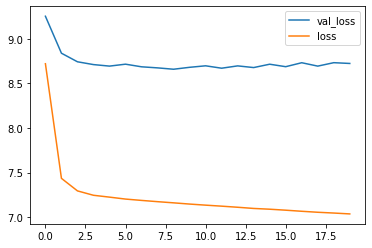

In [280]:
pd.DataFrame(lstm_reg_start.history.history).plot()

In [281]:
mean_squared_error(y_train[~bw_mask_train], lstm_reg_start.predict(X_train[~bw_mask_train]))

7.015099859680466

Some explanations of why training loss different during fit and afterwards:

https://github.com/keras-team/keras/issues/6977

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [282]:
mean_squared_error(y_dev[~bw_mask_dev], lstm_reg_start.predict(X_dev[~bw_mask_dev]))

8.724608248841363

Our error for regular starters with the old LSTM was `8.821628475477073`

In [283]:
is_benchwarmer = lgbm_class.predict(X_dev.reshape(X_dev.shape[0], -1)).astype(bool)
is_benchwarmer

array([ True,  True,  True, ..., False, False, False])

In [284]:
lstm_dev_predictions = lstm_reg_start.predict(X_dev)

In [285]:
lstm_dev_predictions[is_benchwarmer, :] = 0  # Set all 5 GWs to 0 for players predicted as bench warmers

In [286]:
mean_squared_error(y_dev, lstm_dev_predictions)

6.502808812407702

Old LSTM model: 6.467370809515126

In [287]:
is_benchwarmer = lgbm_class.predict(X_train.reshape(X_train.shape[0], -1)).astype(bool)
is_benchwarmer

array([ True,  True,  True, ..., False,  True, False])

In [288]:
lstm_train_predictions = lstm_reg_start.predict(X_train)

In [289]:
lstm_train_predictions[is_benchwarmer, :] = 0

In [290]:
mean_squared_error(y_train, lstm_train_predictions)

4.606776905782736

Old LSTM model: 4.670570694341639

Summary:

- The regular starter LSTM did better than our old LSTM on the ground truth regular starter dev set
- However the regular starter LSTM did worse on the _predicted_ LSTM regular starters dev set
- The predicted set will contain false positives (players who are bench warmers but the model thinks they are regulars). For these players the MSE will be high because the LSTM has not seen this type of player in training.
- Can adjust the cut-off the mitigate this scenario
- Nevertheless this 2-step approach seems like a sensible route forward
- Also, Fantasy Football Scout only has data for players with > 0 minutes, which makes it ideal for the second model.